<a href="https://colab.research.google.com/github/aryanshu/NLP/blob/master/Sentence_similarity_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [44]:
cd "/gdrive/My Drive/Colab Notebooks"

/gdrive/My Drive/Colab Notebooks


In [5]:
!unzip question-pairs-dataset.zip

Archive:  question-pairs-dataset.zip
  inflating: questions.csv           


In [0]:
import pandas as pd
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.metrics import accuracy_score

In [0]:
df=pd.read_csv('questions.csv')

In [60]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df.dropna(inplace=True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
id              404348 non-null int64
qid1            404348 non-null int64
qid2            404348 non-null int64
question1       404348 non-null object
question2       404348 non-null object
is_duplicate    404348 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [65]:
import torch
if torch.cuda.is_available():   
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [66]:
!pip install transformers

In [0]:
from transformers import BertTokenizer

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
df_n=df[100000:110000]
df=df[:100000]

In [0]:
sent1=df.question1.values
sent2=df.question2.values
labels=df.is_duplicate.values


In [74]:
input_ids = []
tokenize_text=[]
for i in range(len(sent1)):
    
    encoded_sent = tokenizer.encode(
                        sent1[i],
                        sent2[i],                     
                        add_special_tokens = True, 
                        max_length=64
            
                   )
    input_ids.append(encoded_sent)

print('Original: ', sent1[0],sent2[0])
print('Token IDs:', input_ids[0])

      


Original:  What is the step by step guide to invest in share market in india? What is the step by step guide to invest in share market?
Token IDs: [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102]


In [0]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 64
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [0]:

attention_masks = []


for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [80]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [85]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

model.zero_grad()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

   
        model.train()
 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()



    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()


    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        

        batch = tuple(t.to(device) for t in batch)
        
   
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    torch.save(model.state_dict(), "models/sent_bert1.pth")

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,813.    Elapsed: 0:00:09.
  Batch    80  of  2,813.    Elapsed: 0:00:19.
  Batch   120  of  2,813.    Elapsed: 0:00:28.
  Batch   160  of  2,813.    Elapsed: 0:00:38.
  Batch   200  of  2,813.    Elapsed: 0:00:47.
  Batch   240  of  2,813.    Elapsed: 0:00:57.
  Batch   280  of  2,813.    Elapsed: 0:01:06.
  Batch   320  of  2,813.    Elapsed: 0:01:15.
  Batch   360  of  2,813.    Elapsed: 0:01:25.
  Batch   400  of  2,813.    Elapsed: 0:01:34.
  Batch   440  of  2,813.    Elapsed: 0:01:43.
  Batch   480  of  2,813.    Elapsed: 0:01:53.
  Batch   520  of  2,813.    Elapsed: 0:02:02.
  Batch   560  of  2,813.    Elapsed: 0:02:12.
  Batch   600  of  2,813.    Elapsed: 0:02:21.
  Batch   640  of  2,813.    Elapsed: 0:02:30.
  Batch   680  of  2,813.    Elapsed: 0:02:40.
  Batch   720  of  2,813.    Elapsed: 0:02:49.
  Batch   760  of  2,813.    Elapsed: 0:02:59.
  Batch   800  of  2,813.    Elapsed: 0:03:08.
  Batch   840  of

##continuing training from cheakpoint

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 1

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [30]:
model2=torch.load('models/sent_bert1.pth')
model.load_state_dict(model2)

<All keys matched successfully>

In [31]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

model.zero_grad()


for epoch_i in range(0, 1):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

   
        model.train()
 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()



    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()


    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        

        batch = tuple(t.to(device) for t in batch)
        
   
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    torch.save(model.state_dict(), "models/sent_bert1.pth")

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  2,194.    Elapsed: 0:00:10.
  Batch    80  of  2,194.    Elapsed: 0:00:19.
  Batch   120  of  2,194.    Elapsed: 0:00:29.
  Batch   160  of  2,194.    Elapsed: 0:00:38.
  Batch   200  of  2,194.    Elapsed: 0:00:48.
  Batch   240  of  2,194.    Elapsed: 0:00:58.
  Batch   280  of  2,194.    Elapsed: 0:01:07.
  Batch   320  of  2,194.    Elapsed: 0:01:17.
  Batch   360  of  2,194.    Elapsed: 0:01:26.
  Batch   400  of  2,194.    Elapsed: 0:01:36.
  Batch   440  of  2,194.    Elapsed: 0:01:45.
  Batch   480  of  2,194.    Elapsed: 0:01:55.
  Batch   520  of  2,194.    Elapsed: 0:02:04.
  Batch   560  of  2,194.    Elapsed: 0:02:14.
  Batch   600  of  2,194.    Elapsed: 0:02:24.
  Batch   640  of  2,194.    Elapsed: 0:02:33.
  Batch   680  of  2,194.    Elapsed: 0:02:43.
  Batch   720  of  2,194.    Elapsed: 0:02:52.
  Batch   760  of  2,194.    Elapsed: 0:03:02.
  Batch   800  of  2,194.    Elapsed: 0:03:11.
  Batch   840  of

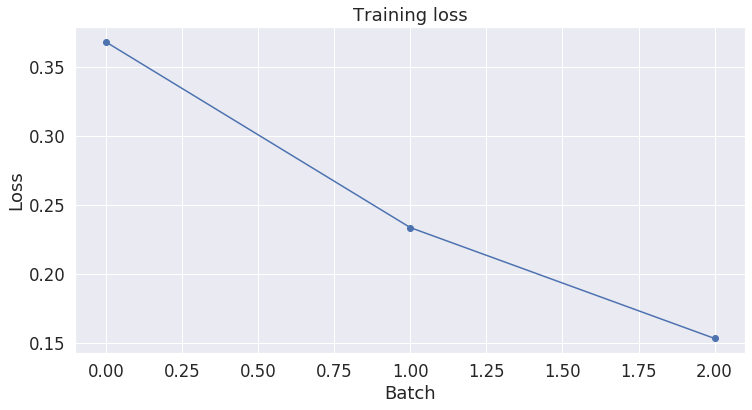

In [86]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.show()

## Ploting loss

##EVALUATING ON TEST SET

In [87]:
model_t = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_t.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# loading saved model

import torch
model2=torch.load("models/sent_bert1.pth")

In [0]:
#df_n.drop(['Unnamed: 0','index'],axis=1,inplace=True)
sent1=df_n.question1.values
sent2=df_n.question2.values
labels=df_n.is_duplicate.values

input_ids = []

tokenize_text=[]
for i in range(len(sent1)):

    encoded_sent = tokenizer.encode(
                        sent1[i],
                        sent2[i],                     
                        add_special_tokens = True, 
                        max_length=128
            
                   )
    input_ids.append(encoded_sent)


from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

batch_size = 16

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [91]:
model_t.load_state_dict(model2)

<All keys matched successfully>

In [93]:
model_t.eval()
 
predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [0]:
pred1=predictions

In [0]:
pred2=[]
for i in range(len(true_labels)):
  pred= np.argmax(pred1[i], axis=1).flatten()
  pred2=pred2+pred.tolist()

In [96]:
pred2=np.asarray(pred2)
true_labels[1]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [0]:
t3=[]
for i in range(len(true_labels)):
  t2= true_labels[i]
  t3=t3+t2.tolist()

In [98]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score 
acc=accuracy_score(pred2,t3)
f1=f1_score(pred2,t3)
precision=precision_score(pred2,t3)
recall=recall_score(pred2,t3)
print(" accuracy={} \n f1={} \n precision={} \n recall={}".format(acc,f1,precision,recall))

 accuracy=0.8763 
 f1=0.8364405659129974 
 precision=0.8623227917121047 
 recall=0.8120667522464698
